# 02. Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can bu multiple things as the options).

## 1. Make classification data and get it ready 

In [1]:
import sklearn 
from sklearn.datasets import make_circles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import requests
from pathlib import Path
from sklearn.datasets import make_blobs
from torchmetrics import Accuracy



torch.__version__

'2.4.0'

In [2]:
# Make 1000 samples 
n_samples = 1000

# Create circles 
X, y = make_circles(n_samples,noise=0.03,random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data 
circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"Label":y})
circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


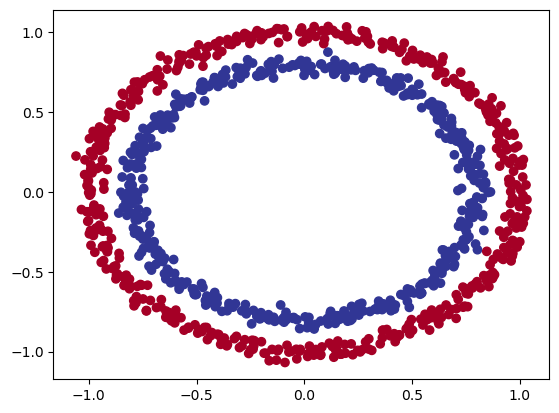

In [6]:
# Visualize , visualize , visualize

plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu);

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundemantals.

### 1.1 Check input and output shapes 


In [7]:
X.shape, y.shape 

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and labels

X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y:{y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y:()


### Turn data into tensors and create train and test splits 

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X) , X.dtype , y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [12]:
# Split data into traininig and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

## 2. Building a model

Lets's build a model to classify our blue and red dots.

To do so , we want to:
1. Setup device agnostic code so our code will run on accelerator (GPU) if  there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optmizer
4. Create a training and test loop 

In [13]:
# Make device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to target `device`

In [14]:
# 1. Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layer capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2,out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)
        
        # Another way of instantiate layers
        #self.two_linear_layers = nn.Sequential(
        #    nn.Linear(in_features=2,out_features=5),
        #    nn.Linear(in_features=5,out_features=1))

    # 3. Define a forward() method that outlines the forward pass
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) # x-> layer_1 -> layer_2 -> output
        # Another way of process forward pass
        #return two_linear_layers(x)

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
device

'cuda'

In [16]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [17]:
# Let's replicate the model above using nn.Squential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0666, -0.2493],
                      [-0.6309,  0.0624],
                      [ 0.0997, -0.0260],
                      [-0.2871,  0.5481],
                      [ 0.2986, -0.2538]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4086, -0.3012, -0.6881, -0.4896, -0.2699], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0250,  0.2672,  0.4231, -0.4117,  0.1210]], device='cuda:0')),
             ('1.bias', tensor([-0.2824], device='cuda:0'))])

In [19]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f'Length of predictions: {len(untrained_preds)} | Shape: {untrained_preds.shape}')
print(f"Length of the test samples: {len(X_test)} | Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200 | Shape: torch.Size([200, 1])
Length of the test samples: 200 | Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-1.],
        [-1.],
        [-0.],
        [-1.],
        [-0.],
        [-0.],
        [-1.],
        [-0.],
        [-0.],
        [-1.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optmizer

Which loss function or optimizer should i use?

Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (crosse ntropy)

As a reminder, the loss function measures how *wrong* your models predictions are.
 
And for optmizers, two of the most common and useful are SGD and ADAM, however PyTorch has many built=in options.

* For some common choices of loss functions and optimizers - https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer
* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on wwhata binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* For a definition on what a logit is in deep  learning -  https://stackoverflow.com/a/52111173
* For different optimizers see `torch.optim`

In [20]:
# Setup the loss function
#loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input BCELoss  
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [21]:
# Calculate accuracy - out of 100 examples, what percantage does our model get right?

def accuracy_fn(y_true, y_pred):
    correct= torch.eq(y_true, y_pred).sum().item()
    acc= (correct/len(y_pred)) * 100

    return acc

### 3. Train Model

To train our model, we're going to need to build a trainig loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optmimizer zero grad
4. Loss backward (backpropagation)
5. Optmizer step (gradient descent) 

### 3.1 Going from raw logits -> prediction probabilites -> prediction labels

Our model outputs going to be raw **logits**

We can convert thesse **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multicalss classification).

Then we can convert our model's prediction probabilites to **prediction labels** by either rounding them or taking the `argmax()`.

In [22]:
# View the first 5 outputsa of the forward pass on the test data 
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.6529],
        [-0.7091],
        [-0.4188],
        [-0.7196],
        [-0.2812]], device='cuda:0')

In [23]:
# Use the sigmoid activation function on our model logits to turn them into prediction 
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3423],
        [0.3298],
        [0.3968],
        [0.3275],
        [0.4302]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [24]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality 
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension 
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [25]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop 

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs 
epochs = 100

# Put data to target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop

for epoch in range(epochs):
    ### Training 
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate accuracy 
    loss = loss_fn(y_logits,y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc= accuracy_fn(y_true= y_train,y_pred= y_pred)

    # Optmizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forawrd pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)        

        # Print out what's happeninig 
        print(f"Train Epoch: {epoch} | Train Loss: {loss:.5f} | Train Accuracy:{acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy:{test_acc:.2f}%")
        

Train Epoch: 0 | Train Loss: 0.72479 | Train Accuracy:50.00% | Test Loss: 0.71767 | Test Accuracy:50.00%
Train Epoch: 1 | Train Loss: 0.72162 | Train Accuracy:50.00% | Test Loss: 0.71478 | Test Accuracy:50.00%
Train Epoch: 2 | Train Loss: 0.71881 | Train Accuracy:50.00% | Test Loss: 0.71222 | Test Accuracy:50.00%
Train Epoch: 3 | Train Loss: 0.71632 | Train Accuracy:50.00% | Test Loss: 0.70995 | Test Accuracy:50.00%
Train Epoch: 4 | Train Loss: 0.71412 | Train Accuracy:50.00% | Test Loss: 0.70793 | Test Accuracy:50.00%
Train Epoch: 5 | Train Loss: 0.71217 | Train Accuracy:50.00% | Test Loss: 0.70614 | Test Accuracy:50.00%
Train Epoch: 6 | Train Loss: 0.71044 | Train Accuracy:50.00% | Test Loss: 0.70456 | Test Accuracy:50.00%
Train Epoch: 7 | Train Loss: 0.70891 | Train Accuracy:50.00% | Test Loss: 0.70315 | Test Accuracy:50.00%
Train Epoch: 8 | Train Loss: 0.70754 | Train Accuracy:50.00% | Test Loss: 0.70189 | Test Accuracy:50.00%
Train Epoch: 9 | Train Loss: 0.70633 | Train Accuracy:5

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!!"

To do so, we're going to import a function called `plot_decision_boundary()`

In [27]:
# Download helper functions
if Path("helper_functions.py").is_file():
    print('helper_functions.py already exists, skipping download')

else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


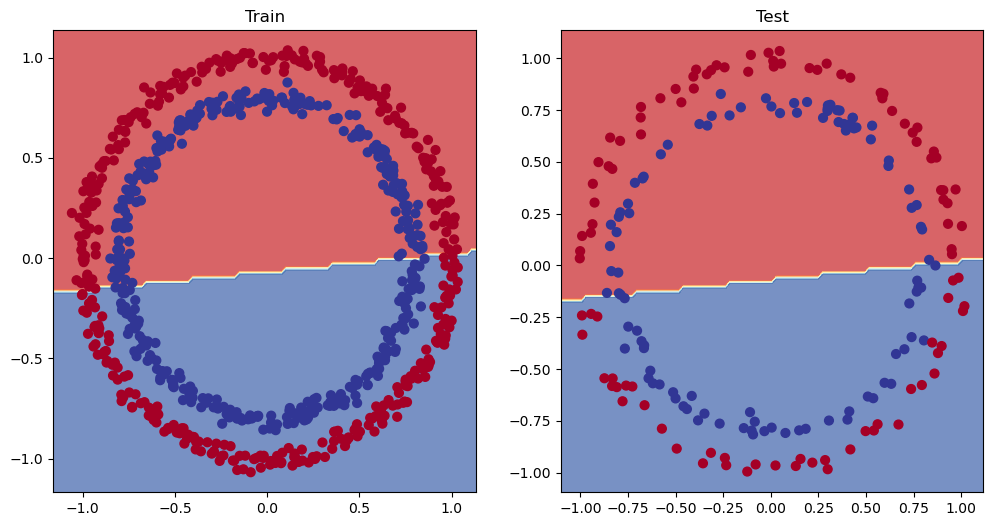

In [28]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data.
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learninig rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5->10
* Increase the number of layers: 2->3
* Increase the number of epochs: 100->1000
  

In [29]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1= nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
# Create a loss function
loss_fn_1 = nn.BCEWithLogitsLoss()
# Create an optimizer
optim_1 = torch.optim.SGD(params=model_1.parameters(),lr =0.1)

In [31]:
# Write a training and evalluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# train for longer
epochs =1000

# Put data on the target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):

    ### Training
    model_1.train()

    # 1. Forward Pass
    y_logits =  model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> prediction labels

    # 2. Calculate the loss/ accuracy
    loss = loss_fn_1(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred) 

    # 3. Optimizer Zero Grad
    optimizer.zero_grad()

    # 4. Loss Backward (backpropagation)
    loss.backward()

    # 5. Optmizer Step (gradient descent)
    optimizer.step()

    ### Testint

    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the loss
        test_loss = loss_fn_1(test_logits,y_test)
        
        # 3. Calculate the accuracy
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_preds)

        if epoch %5 == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epoch: 5 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epoch: 10 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epoch: 15 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epoch: 20 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epoch: 25 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epoch: 30 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epoch: 35 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epoch: 40 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epoch: 45 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test

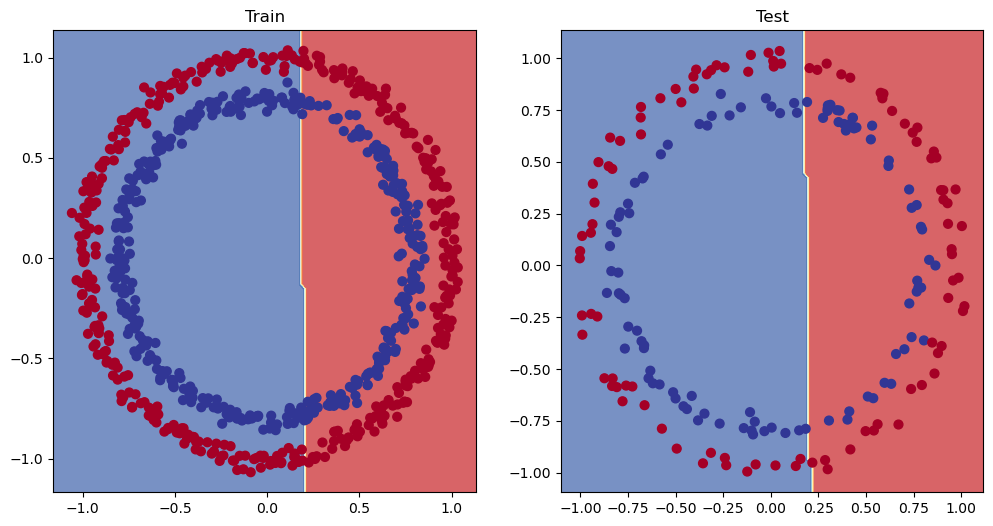

In [32]:
# Plot the decision boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

### 5.1 Preparing data to see if our model can fit a straight line 

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [33]:
# Createa some data (same as notebook 01)
weight = 0.7
bias = 0.3
start=0
end=1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5],y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [34]:
# Create train and test split
train_split= int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split],y_regression[:train_split]
X_test_regression, y_test_regression= X_regression[train_split:],y_regression[train_split:]

# Check the lengts each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

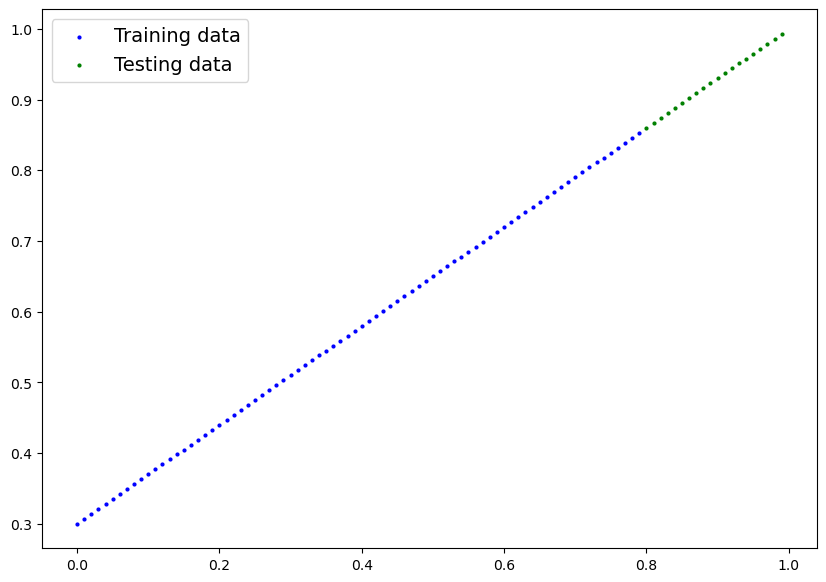

In [35]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data= X_test_regression, test_labels=y_test_regression);


In [36]:
# Same architecture as model_1 (but using nn.Sequentiall())

model_2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
# Loss and optimizer 
loss_fn_2 = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),lr= 0.1)

In [38]:
# Train the model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs=1000

# Put the data on the target device
X_train_regression,y_train_regression = X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    # 1. Forward Pass
    y_preds = model_2(X_train_regression)
    
    # 2. Calculate the loss
    loss = loss_fn_2(y_preds, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward (backpropagation)
    loss.backward()

    # 5. Optimizer Step (SGD)
    optimizer.step() 


    # Testing
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward Pass
        test_preds = model_2(X_test_regression)

        # 2. Calculate the test loss
        test_loss = loss_fn_2(test_preds,y_test_regression)

    if epoch % 5 ==0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Test loss: {test_loss:.5f}")



Epoch: 0 | Train loss: 0.75986 | Test loss: 0.54143
Epoch: 5 | Train loss: 0.20667 | Test loss: 0.24162
Epoch: 10 | Train loss: 0.14550 | Test loss: 0.02363
Epoch: 15 | Train loss: 0.07663 | Test loss: 0.25086
Epoch: 20 | Train loss: 0.14420 | Test loss: 0.05597
Epoch: 25 | Train loss: 0.07546 | Test loss: 0.24887
Epoch: 30 | Train loss: 0.10136 | Test loss: 0.03785
Epoch: 35 | Train loss: 0.06854 | Test loss: 0.20187
Epoch: 40 | Train loss: 0.07525 | Test loss: 0.00984
Epoch: 45 | Train loss: 0.06796 | Test loss: 0.21320
Epoch: 50 | Train loss: 0.07625 | Test loss: 0.02102
Epoch: 55 | Train loss: 0.07805 | Test loss: 0.22796
Epoch: 60 | Train loss: 0.10320 | Test loss: 0.02754
Epoch: 65 | Train loss: 0.06252 | Test loss: 0.17427
Epoch: 70 | Train loss: 0.08643 | Test loss: 0.01007
Epoch: 75 | Train loss: 0.05800 | Test loss: 0.20038
Epoch: 80 | Train loss: 0.06937 | Test loss: 0.01326
Epoch: 85 | Train loss: 0.06673 | Test loss: 0.19902
Epoch: 90 | Train loss: 0.08678 | Test loss: 0.0

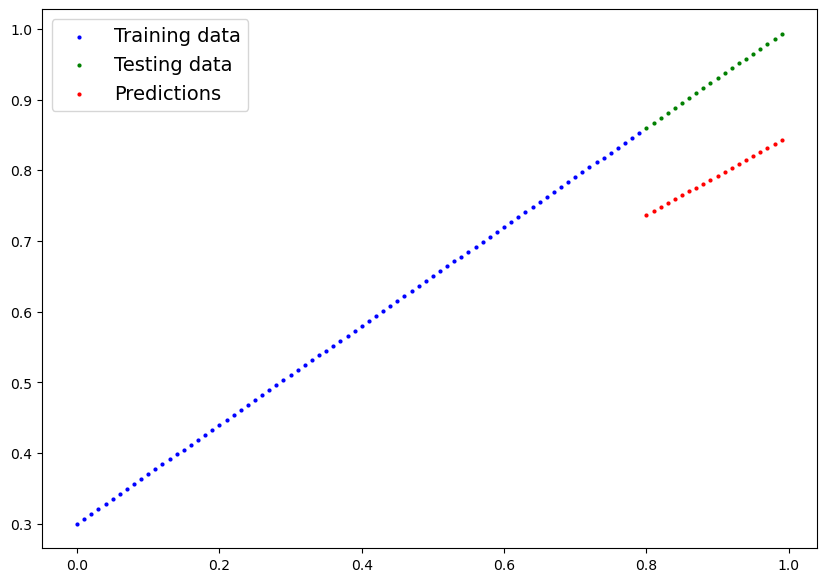

In [39]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds= model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),train_labels=y_train_regression.cpu(),test_data=X_test_regression.cpu(),test_labels=y_test_regression.cpu(),predictions=y_preds.cpu());

### 6. The missing piece: non-linearity

"What patterns could yo draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learninig terms, an infinite (but really it is finite) of linear and non-linear functions?



### 6.1 Recreating non-linear data (red and blue circles)



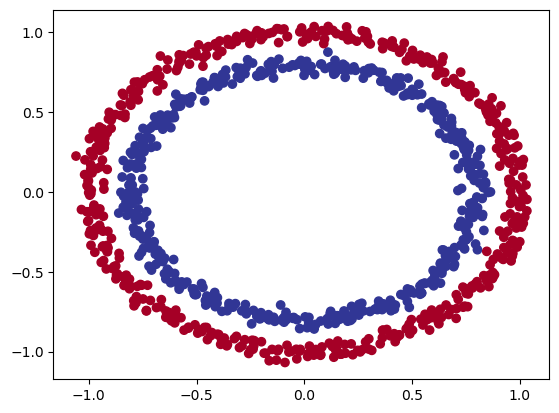

In [40]:
# Make and plot data

n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu);

In [41]:
### Convert data to tensors and then to train and test splits

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float).squeeze()
y = torch.from_numpy(y).type(torch.float)

# Split into train and test
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)


X_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

Artifical neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [42]:
# Build a modell with non-linaer activation functions

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU() # relu is a non-linear activation function

    def forward(self,x):
        # Where should we put our non-linear activation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [43]:
# Set up loss and optimizer

loss_fn_3 = nn.BCEWithLogitsLoss()
optimizer_3 =torch.optim.SGD(params= model_3.parameters(),lr= 0.1)

### 6.3 Training a model with non-linearity

In [44]:
#Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device 
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilites -> prediction labels

    # 2. Calculate the loss
    loss = loss_fn_3(y_logits,y_train)
    acc = accuracy_fn(y_train,y_pred)

    # 3. Optimizer zero grad
    optimizer_3.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (SGD)
    optimizer_3.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():

        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the loss and acc
        test_loss = loss_fn_3(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_preds)

    # Print out what's happenin
    if epoch %5 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69295 | Train Accuracy: 50.00% | Test Loss: 0.69319 | Test Accuracy: 50.00%
Epoch: 5 | Train Loss: 0.69268 | Train Accuracy: 50.00% | Test Loss: 0.69286 | Test Accuracy: 50.00%
Epoch: 10 | Train Loss: 0.69248 | Train Accuracy: 50.50% | Test Loss: 0.69260 | Test Accuracy: 50.00%
Epoch: 15 | Train Loss: 0.69234 | Train Accuracy: 53.87% | Test Loss: 0.69242 | Test Accuracy: 51.00%
Epoch: 20 | Train Loss: 0.69225 | Train Accuracy: 59.13% | Test Loss: 0.69231 | Test Accuracy: 56.50%
Epoch: 25 | Train Loss: 0.69217 | Train Accuracy: 64.25% | Test Loss: 0.69221 | Test Accuracy: 63.00%
Epoch: 30 | Train Loss: 0.69209 | Train Accuracy: 70.25% | Test Loss: 0.69212 | Test Accuracy: 68.00%
Epoch: 35 | Train Loss: 0.69202 | Train Accuracy: 70.38% | Test Loss: 0.69203 | Test Accuracy: 70.50%
Epoch: 40 | Train Loss: 0.69195 | Train Accuracy: 68.38% | Test Loss: 0.69195 | Test Accuracy: 71.00%
Epoch: 45 | Train Loss: 0.69188 | Train Accuracy: 63.12% | Test Loss: 0.69186 | Test

### 6.4 Evaluating a model trained with non-linear activation functions

In [45]:
# Make predictions

model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10],y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

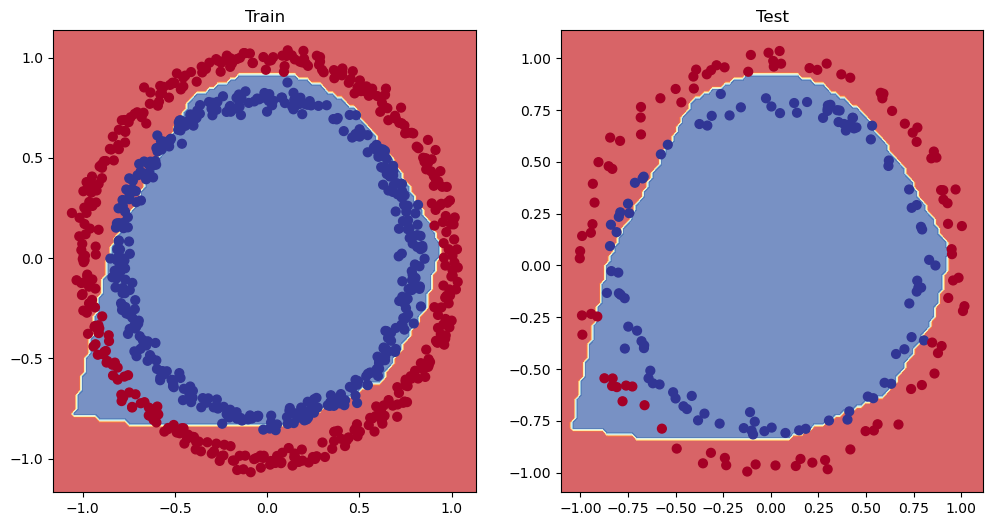

In [46]:
# Plot decision boundaries 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.


In [47]:
# Create a tensor 
A = torch.arange(-10,10,1,dtype=torch.float32)

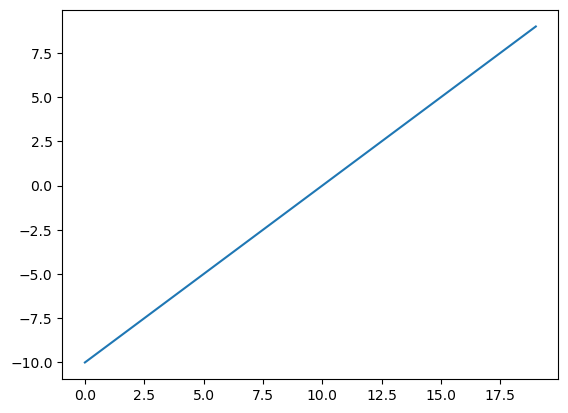

In [48]:
# Visualize the tensor 

plt.plot(A);

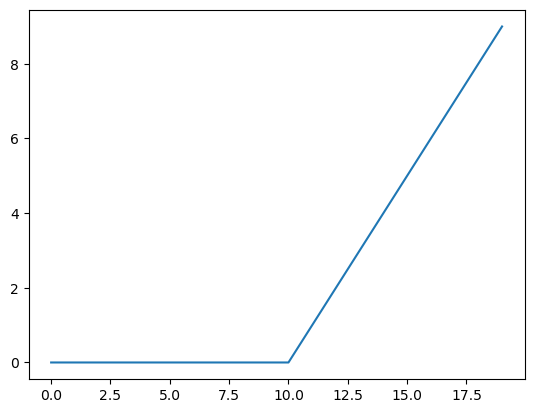

In [49]:
plt.plot(torch.relu(A));

In [50]:
def relu(x: torch.Tensor) -> torch.Tensor : 
    return torch.maximum(torch.tensor(0),x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

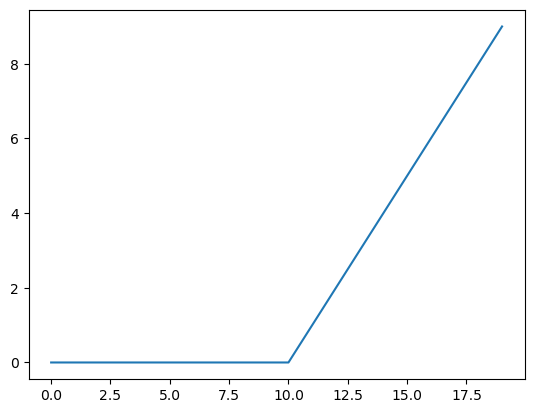

In [51]:
# Plot ReLU activation function

plt.plot(relu(A))

In [52]:
# Now let's do the same for Sigmoid = https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))




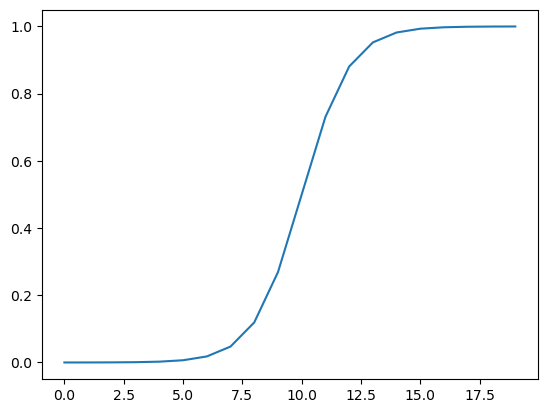

In [53]:
plt.plot(torch.sigmoid(A))

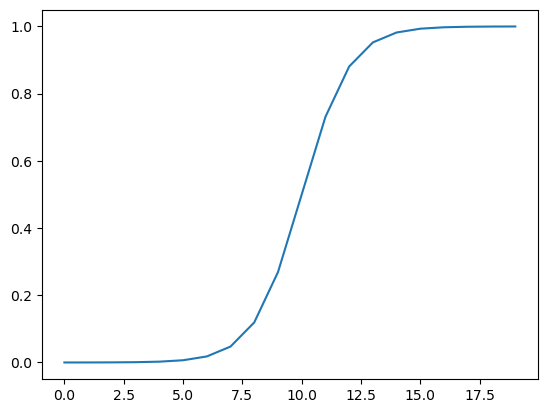

In [54]:
plt.plot(sigmoid(A))

## Putting all together with a multi-class classification problem 

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification - more than one thing or another (cat vs. dog vs. chicken)
  

### 8.1 Creating a toy multi-class dataset

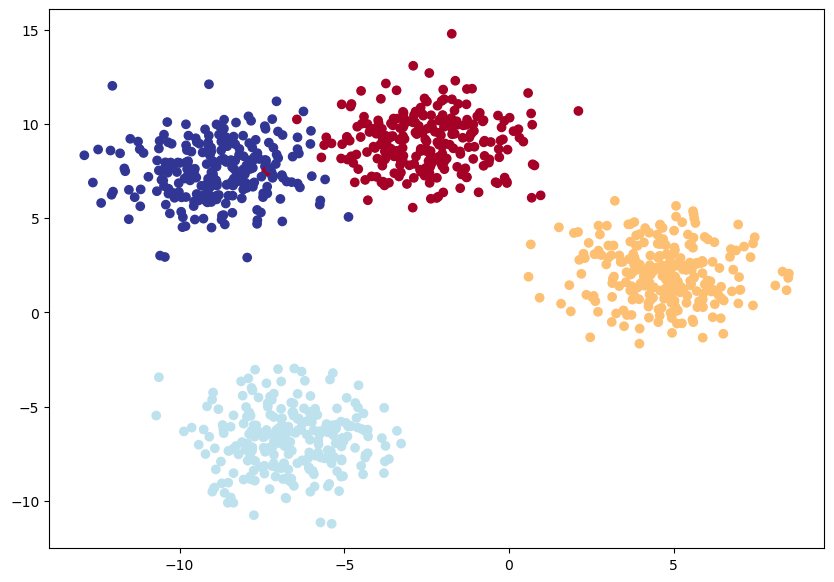

In [55]:
# Set the hyperparameters for data creation

NUM_CLASSES = 4
NUM_FEATURES= 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples= 1000, 
                            n_features=NUM_FEATURES, 
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1], c=y_blob,cmap=plt.cm.RdYlBu )

### 8.2 Building a multi=class classification model in PyTorch

In [56]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [57]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification model

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8

        Returns:

        Example:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )

    def forward(self,x):
        return self.linear_layer_stack(x)
    
# Create an instance of BlobModel and send it to target device
model_4= BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optmizer for a multi-classs classification model

In [58]:
# Create loss function for multi-class classification
loss_fn_4 = nn.CrossEntropyLoss() # for more: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

# Create an optimizer for multi-class classification
optimizer_4= torch.optim.SGD(params=model_4.parameters(),lr=0.1)

### 8.4 Getting prediction probabilites for a multi-class PyTorch Model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) prediction probabilites and then to prediction labels.

Logits (raw output of the model) -> Pred Probs (use `torch.softmax`)-> Pred Labels (take the argmax of the prediction probabilites)

In [59]:
# Let's get some raw outputs of our model
X_blob_train,y_blob_train= X_blob_train.to(device),y_blob_train.to(device)
X_blob_test, y_blob_test= X_blob_test.to(device), y_blob_test.to(device)

model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [60]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [61]:
# Convert our model's prediction probabilites to prediction labels
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [62]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

### 8.5 Craeting a training loop and testing loop for multi-clas PyTorch model

In [63]:
# Fit the molti-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs=100

# Loop through data
for epoch in range(epochs):
    ### Training
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

    loss = loss_fn_4(y_logits,y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,y_pred= y_pred)  

    optimizer_4.zero_grad()

    loss.backward()

    optimizer_4.step()


    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

        test_loss = loss_fn_4(test_logits,y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,y_pred=test_preds)

    if epoch % 5 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss} | Train Accuracy: {acc} | Test Loss: {test_loss} | Test Accuracy: {test_acc}")

Epoch: 0 | Train Loss: 1.158826470375061 | Train Accuracy: 40.375 | Test Loss: 1.0755419731140137 | Test Accuracy: 48.0
Epoch: 5 | Train Loss: 0.802255392074585 | Train Accuracy: 91.125 | Test Loss: 0.802717924118042 | Test Accuracy: 94.0
Epoch: 10 | Train Loss: 0.6447554230690002 | Train Accuracy: 96.75 | Test Loss: 0.660687267780304 | Test Accuracy: 97.5
Epoch: 15 | Train Loss: 0.5305079221725464 | Train Accuracy: 98.375 | Test Loss: 0.5418548583984375 | Test Accuracy: 99.5
Epoch: 20 | Train Loss: 0.42535150051116943 | Train Accuracy: 98.5 | Test Loss: 0.43074119091033936 | Test Accuracy: 100.0
Epoch: 25 | Train Loss: 0.3354519307613373 | Train Accuracy: 99.125 | Test Loss: 0.33523884415626526 | Test Accuracy: 100.0
Epoch: 30 | Train Loss: 0.2529423236846924 | Train Accuracy: 99.125 | Test Loss: 0.24507617950439453 | Test Accuracy: 99.5
Epoch: 35 | Train Loss: 0.17119088768959045 | Train Accuracy: 99.25 | Test Loss: 0.15899601578712463 | Test Accuracy: 99.5
Epoch: 40 | Train Loss: 0.

### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [64]:
# Make Predictions 

model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    

# View the first 10 predictions 
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [65]:
# Go from logits -> Prediction Probabilites
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [66]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

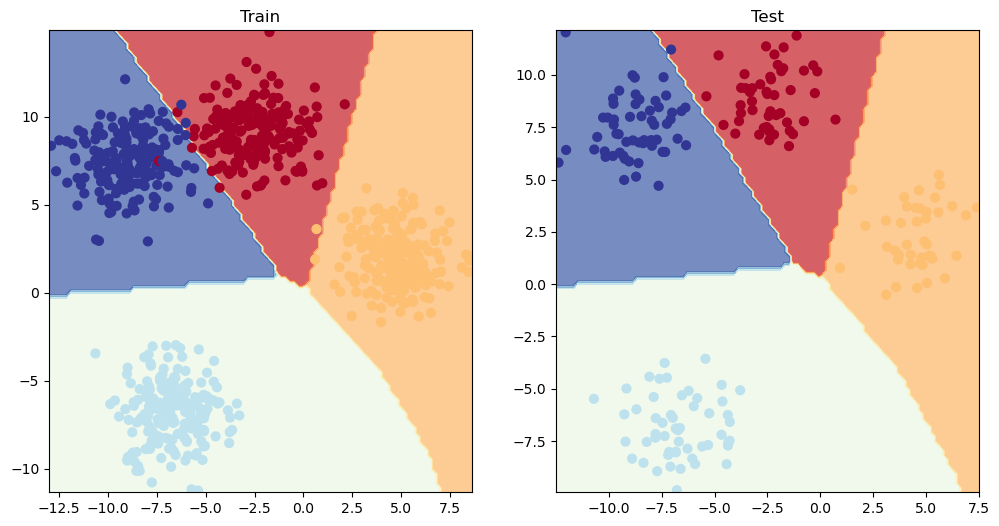

In [67]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

### 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification Report

See this articlle when to use precision/recall - https://willkoehrsen.github.io/statistics/learning/beyond-accuracy-precision-and-recall/ 

 https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics

 If you want access to a lot of PyTorch metrics, see TorchMetrics - https://lightning.ai/docs/torchmetrics/stable/

In [68]:
# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass",num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds,y_blob_test)

tensor(0.9950, device='cuda:0')